# Préparation des données pour LexImpact

Ce projet regroupe les scripts permettant de préparer les données des différents projets [Leximpact](https://leximpact.an.fr).

In [ ]:
# | hide

# https://diagrams.mingrammer.com/docs/nodes/programming
from diagrams import Cluster, Diagram
from diagrams.firebase.develop import Authentication
from diagrams.gcp.compute import AppEngine, Functions
from diagrams.gcp.database import SQL
from diagrams.gcp.security import Iam
from diagrams.gcp.storage import GCS
from diagrams.onprem.client import User
from diagrams.onprem.inmemory import Redis
from diagrams.programming.framework import Fastapi
from diagrams.programming.language import Nodejs, Python

In [ ]:
# | hide
trans_clus_attr = {
    # "rankdir":"TB"
    # "bgcolor": "transparent",
    # "pencolor":"transparent",
    "style": "invis"
}

tb_attr = {"rankdir": "TB"}

graph_attr = {
    # "rankdir":"TB",
    "splines": "polyline",  #  ortho
    "fontsize": "40",
    # "size": "10-40",
    # "height": "30",
    # "dpi": "96",
}

with Diagram(
    "Schéma simplifié de la création de la base LexImpact",
    show=False,
    filename="schemas/leximpact_pipeline_simple",
    outformat="png",
    graph_attr=graph_attr,
    node_attr={
        "fontsize": "15",
    },
) as diag:
    # Icone de traitement
    trt = AppEngine
    erfs = SQL("ERFS-FPR")

    with Cluster(
        "Traitements sur le CASD",
        graph_attr={
            "fontsize": "15",
        },
    ):
        copules = GCS("Fonction de\nrépartition")
        calib = GCS("Distribution")
        GCS("POTE") >> [calib, copules]
    with Cluster(
        "Préparation de notre base de données",
        graph_attr={
            "fontsize": "15",
        },
    ):
        with Cluster("prepare1", graph_attr=trans_clus_attr) as prepare1:
            reduc = AppEngine("Réduction du\nnombre de\nvariables")
            rfr_calib = trt("Calibration")
            vieille = trt("Vieillissement")
            ofd = trt("Open-Fisca\nFrance Data")

            (erfs >> ofd >> reduc >> trt("Ajout individus") >> rfr_calib >> vieille)
        with Cluster("prepare2", graph_attr=trans_clus_attr) as prepare2:
            use_copules = trt("Ajout de données")
            base_finale = Redis("Base LexImpact")
            bruit = trt("Bruitage")
            # grp2 = [use_copules, erfs_final, bruit]
            (use_copules >> bruit >> base_finale)
        calib >> rfr_calib
        copules >> use_copules
        vieille >> use_copules

    User("Utilisateur") << base_finale

diag

ExecutableNotFound: failed to execute ['dot', '-Kdot', '-Tpng', '-O', 'leximpact_pipeline_simple'], make sure the Graphviz executables are on your systems' PATH

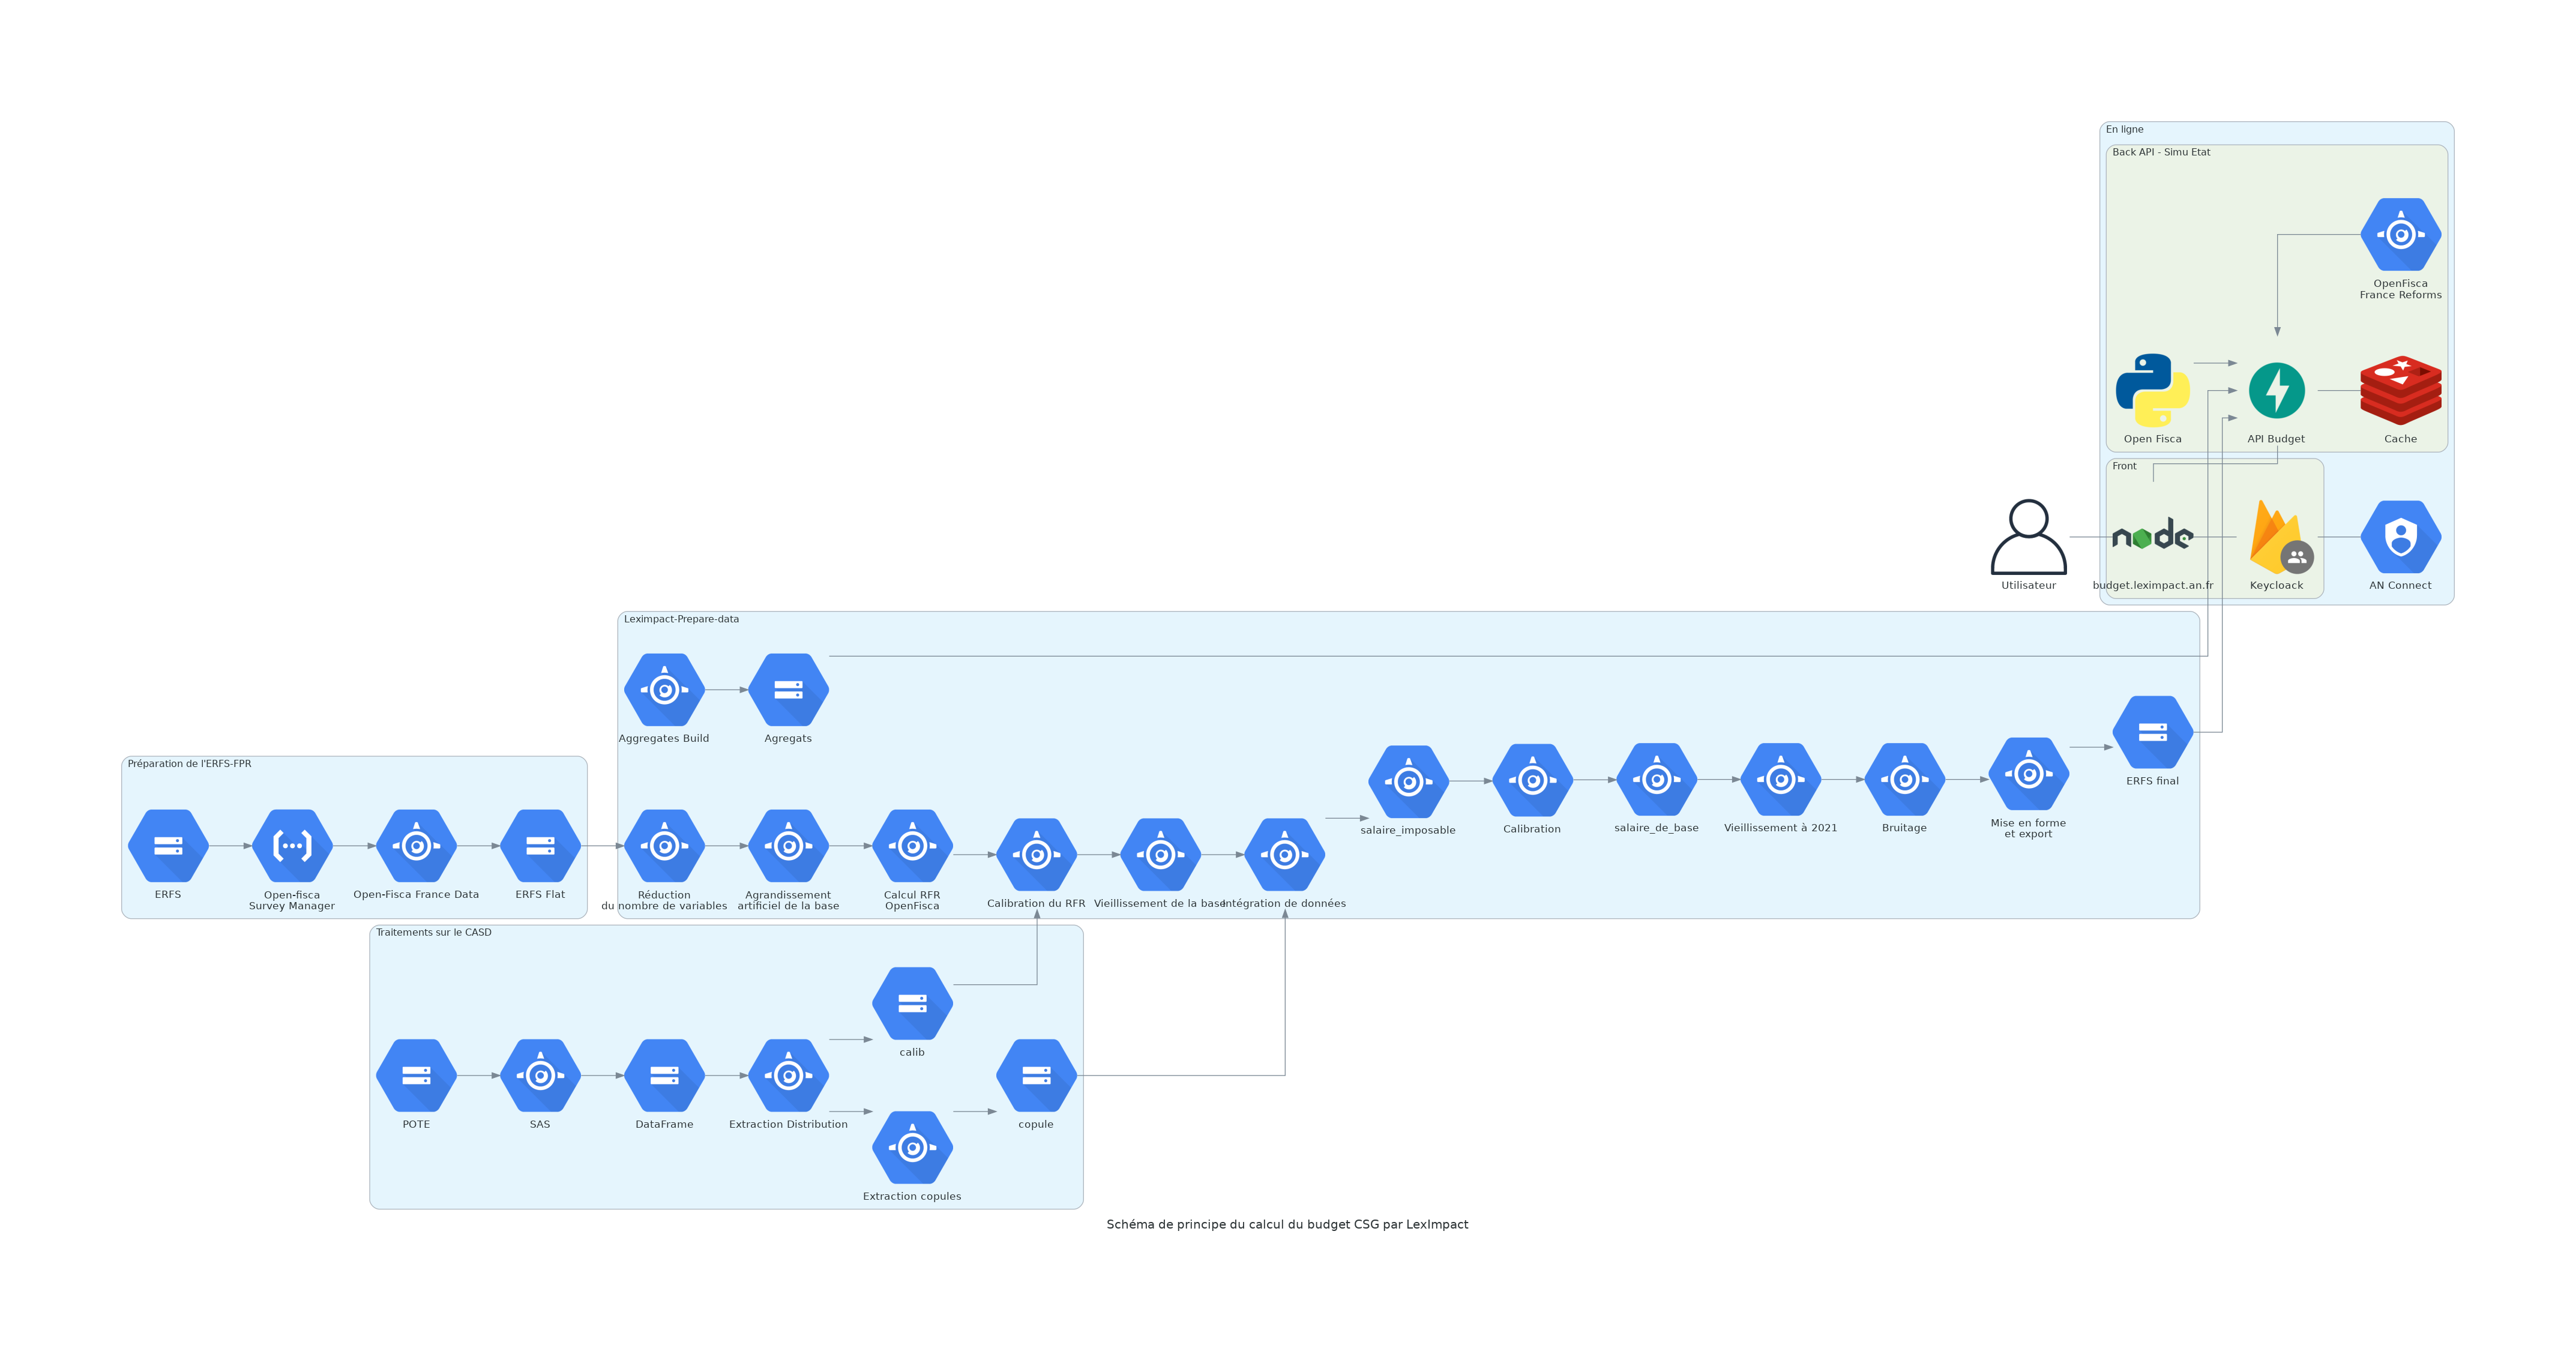

In [ ]:
# | hide


with Diagram(
    "Schéma de principe du calcul du budget CSG par LexImpact",
    show=False,
    filename="schemas/leximpact_pipeline",
) as diag:
    # Icone de traitement
    trt = AppEngine

    with Cluster("Préparation de l'ERFS-FPR"):
        erfs_flat = GCS("ERFS Flat")
        (
            GCS("ERFS")
            >> Functions("Open-fisca\nSurvey Manager")
            >> trt("Open-Fisca France Data")
            >> erfs_flat
        )

    with Cluster("Traitements sur le CASD"):
        copules = GCS("copule")
        calib = GCS("calib")
        ex_calib = AppEngine("Extraction Distribution")
        ex_copules = AppEngine("Extraction copules")
        GCS("POTE") >> AppEngine("SAS") >> GCS("DataFrame") >> ex_calib >> ex_copules
        ex_calib >> calib
        ex_copules >> copules

    with Cluster("Leximpact-Prepare-data"):
        erfs_final = GCS("ERFS final")
        agregats = GCS("Agregats")
        reduc = AppEngine("Réduction\ndu nombre de variables")
        rfr_calib = trt("Calibration du RFR")
        use_copules = trt("Intégration de données")
        (
            erfs_flat
            >> reduc
            >> trt("Agrandissement\nartificiel de la base")
            >> trt("Calcul RFR\nOpenFisca")
            >> rfr_calib
            >> trt("Vieillissement de la base")
            >> use_copules
            >> trt("salaire_imposable")
            >> trt("Calibration")
            >> trt("salaire_de_base")
            >> trt("Vieillissement à 2021")
            >> trt("Bruitage")
            >> trt("Mise en forme\net export")
            >> erfs_final
        )
        trt("Aggregates Build") >> agregats
        calib >> rfr_calib
        copules >> use_copules

    with Cluster("En ligne"):
        with Cluster("Back API - Simu Etat"):
            api = Fastapi("API Budget")
            Python("Open Fisca") >> api
            agregats >> api
            erfs_final >> api
            api - Redis("Cache")
            api << trt("OpenFisca\nFrance Reforms")

        with Cluster("Front"):
            budget = Nodejs("budget.leximpact.an.fr")
            key = Authentication("Keycloack")
            budget - key
            budget - api
        key - Iam("AN Connect")
    User("Utilisateur") - budget

diag

## Schéma complet de préparation et d'utilisation des données
![LexImpact Pipeline](schemas/leximpact_pipeline.png)

In [ ]:
# | hide
# https://github.com/innovationOUtside/ipython_magic_blockdiag
# https://ipydrawio.readthedocs.io/en/stable/

# Etapes de préparation de la base de données

Le socle de la simulation budgétaire est l'[ERFS-FPR](https://data.progedo.fr/series/adisp/enquetes-revenus-fiscaux-erf-enquetes-revenus-fiscaux-et-sociaux-erfs) (ERFS) c'est-à-dire la version "fichiers de production et de recherche (FPR)" de l'[Enquête revenus fiscaux et sociaux](https://www.insee.fr/fr/metadonnees/source/serie/s1231) produite par l'INSEE. L'ERFS est une enquête annuelle sur un échantillon de 50 000 ménages ordinaires résidant en France métropolitaine. Elle recueille les différents types de revenus des ménages ainsi que les caractéristiques sociodémographiques de ceux-ci. Si les informations présentes dans ces données sont très fines, notamment pour les catégories de revenus, ces données ne sont accessibles que via le Centre d'accès sécurisé au données (CASD) ce qui ne nous permet pas de développer un outil utilisable de manière autonome. 
De ce fait nous utilisons la version FPR de cette base, qui contient des données moins détaillées mais qui peut être utilisée via notre serveur sécurisé et permet une utilisation de notre simulateur pour les personnes habilitées.

## 1- Retraitement de l'ERFS-FPR

*Fonction [build() définie dans openfisca-france-data](https://github.com/openfisca/openfisca-france-data/blob/master/openfisca_france_data/erfs_fpr/input_data_builder/__init__.py)*

Cette étape vise à adapter la base de données brute de l'ERFS-FPR en un format compatible avec le moteur de calcul [OpenFisca](https://fr.openfisca.org/). Il s'agit notamment de :

- Sélectionner les variables nécessaires aux calculs. Ainsi sur les plusieurs centaines de variables présentes dans la base initiale, moins de 50 sont utilisées dans notre modèle.

- Renommer les variables pour qu'elles correspondent aux noms des variables openfisca.

- Calculer certaines variables qui ne sont pas dans la base brute mais qui seront en entrée du modèle. Principalement : 
    * Déterminer les foyers fiscaux et les familles au sens des prestations sociales à partir des liens de parenté et des statuts conjugaux des individus dans les ménages.
    * Déterminer le statut d'activité principal dans l'année (actif en emploi, chômeur, retraité, étudiant, inactif, etc...) ainsi que les caractéristiques de l'emploi (type d'activité, contrat de travail, quotité travaillée dans l'année, etc.. ) en fonction des variables de l'enquête emploi.

- Restructurer les données afin d'obtenir une table par entité d'openfisca : individu, famille, foyer fiscal et ménage.

--> A la fin de cette étape on obtient des données au format `.h5` directement utilisables avec openfisca. Cependant certaines variables sont trop agrégées pour pouvoir réaliser des simulations satisfaisantes. Dans les étapes suivantes ces données sont donc augmentées d'informations en provenance de bases de données plus précises.


## 2- Ajout de variables issues de POTE et de l'ERFS

### Création de copules de variables de POTE sur le CASD

*dossier [extractions_base_des_impots de leximpact-prepare-data](https://git.leximpact.dev/leximpact/simulateur-socio-fiscal/budget/leximpact-prepare-data/-/tree/master/notebooks/code_CASD/extractions_base_des_impots)*

Nous utilisons les données exhaustives de déclarations fiscales POTE, accessibles par un accès sécurisé, pour enrichir les informations de revenus de notre base de données. Pour ce faire nous réalisons des copules, ou distributions croisées dans POTE.

Les variables concernées :

- Les revenus du capital imposables, notamment : 
    * Les revenus fonciers
    * Les revenus du capital soumis ou non au prélèvement forfaitaire unique (PFU)
    * Les plus-values soumises ou non au PFU
    * Les rentes viagères à titre onéreux

Pour cette première catégorie de variables la variable primaire est la somme des revenus individuels des membres du foyer fiscal, hors PACS, c'est à dire la somme des salaires, revenus des non salariés, retraites, allocations chômage, pensions alimentaire et d'invalidité. Il s'agit de l'ensemble des informations de revenus que nous avons dans la base ERFS-FPR à l'issue de l'étape précédente.

- Des variables rentrant en compte dans le calcul de l'impôt sur le revenus
    * Les charges déductibles
    * Les réductions d'impôt
    * Les crédits d'impot
    * Les cases fiscales ouvrant droit à des demi parts fiscales complémentaires

Pour cette seconde catégorie la variable primaire est le revenu fiscal de référence divisé par le nombre de part fiscal dans le foyer. Cela pour faire une imputation sur la même dimension que la représentation graphique finale.

Pour chaque variables ci dessus la création du copule se fait en deux temps. D'abord on divise les observations en quantile de la variable primaire. Par quantile de variable primaire on calcule les quantiles de variables cibles. Ainsi pour chaque groupe de variable primaire on obtient la distribution de la variable cible. Cela nous permet d'obtenir une distribution fine de la variable que l'on veut ajouter à notre base de données.

### Imputation des variables d'après les copules

*méthode [build_imputation() de PipelineErfsSurveyScenario](https://git.leximpact.dev/leximpact/simulateur-socio-fiscal/budget/leximpact-prepare-data/-/blob/master/leximpact_prepare_data/pipeline_survey_scenario.py)*

*commande `build_pipeline` dans le paquet leximpact-prepare-data*

Pour ajouter les variables dont on a fait les copules précédement, on classe la base de données ERFS-FPR d'après la même variable primaire que celle utilisée pour faire les copules. Puis dans chaque quantile de variable primaire on tire un nombre de foyers auxquels une imputation de revenus va être faite, en fonction de la part de foyers ayant ce revenus observée dans les copules. Pour chaque foyer sélectionne on tire ensuite un montant de revenu dans la distribution de son quantile.

On réalise cette opération variable imputée par variable imputée. Un ménage tiré pour une catégorie de revenu ne le sera pas forcément pour une autre catégorie.

Après cette étape on obtient ainsi une base de donnée avec des infomations de revenus précis pour l'année de POTE utilisée.


## 3- Vieillissement des données jusqu'à l'année de simulation

Il y a deux ou trois ans de décalage entre la dernière année de POTE disponible et l'année en cours pour la simulation. Pour vieillir les données jusqu'à l'année de simulation nous utilisons les grands agrégats de prévisions produits par l'INSEE ou les ministères ou moment du projet de loi de finances.

## 4- Recalage des agrégats des dispositifs calculés : impôt sur le revenu, csg sur les salaires et sur les retraites

La dernière étape de la préparation des données est de caler la simulation sur les agrégats. Du fait des limites de nos données nos calculs comportent une marge d'erreur et ne nous retrouvons pas exactement les masses de prélèvements 

# How to contribute

Please see the [contributing page](https://documentation.leximpact.dev/leximpact_prepare_data/contributing.html).